In [3]:
# Cell 1: Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

In [4]:
# Cell 2: Load the dataset
df = pd.read_csv('data.csv')

# Display the first few rows of the dataset
df.head()

,dataset,scenario,details,user,start,end
0,4,1,r4_1_301.csv,628R3BWZ,2010-01-01 01:05:27,2010-01-01 01:54:27
1,3,2,r3_2_480.csv,YVVFNOI8,2010-01-01 13:18:26,2010-01-01 15:09:26
2,4,3,r4_3_245.csv,8V97FG80,2010-01-02 03:44:21,2010-01-02 05:16:21
3,4,2,r4_2_407.csv,D8GOUEWJ,2010-01-02 06:36:56,2010-01-02 07:55:56
4,2,3,r2_3_804.csv,FO68BF45,2010-01-03 15:34:04,2010-01-03 15:39:04


In [5]:
# Cell 3: Basic data preprocessing
# Convert 'start' and 'end' to datetime
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Add a new feature for the duration of events in seconds
df['duration'] = (df['end'] - df['start']).dt.total_seconds()

# Drop unnecessary columns
df.drop(columns=['details', 'user', 'start', 'end'], inplace=True)

# Check for missing values
print(df.isnull().sum())

dataset     0
scenario    0
duration    0
dtype: int64


In [6]:
# Cell 4: Handling missing values
imputer = SimpleImputer(strategy='mean')
df['duration'] = imputer.fit_transform(df[['duration']])

# Check if there are still missing values
print(df.isnull().sum())

dataset     0
scenario    0
duration    0
dtype: int64


In [7]:
# Cell 5: Train-test split
X = df.drop('scenario', axis=1)  # Features
y = df['scenario']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Cell 6: Baseline Accuracy
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Baseline Accuracy: 0.3200


In [9]:
# Cell 7: One-Hot Encoding
X_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align the columns of the test set to the train set
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Train and evaluate the model again
model.fit(X_encoded, y_train)
y_pred = model.predict(X_test_encoded)

accuracy_encoded = accuracy_score(y_test, y_pred)
print(f'Accuracy after One-Hot Encoding: {accuracy_encoded:.4f}')

Accuracy after One-Hot Encoding: 0.3200


In [10]:
# Cell 8: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Train and evaluate the model again
model.fit(X_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy_scaled = accuracy_score(y_test, y_pred)
print(f'Accuracy after Standardization: {accuracy_scaled:.4f}')

Accuracy after Standardization: 0.3050


In [11]:
# Cell 9: SMOTE for Imbalanced Datasets
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y_train)

# Train and evaluate using the balanced dataset
model.fit(X_smote, y_smote)
y_pred = model.predict(X_test_scaled)

accuracy_smote = accuracy_score(y_test, y_pred)
print(f'Accuracy after SMOTE: {accuracy_smote:.4f}')

Accuracy after SMOTE: 0.3050


In [12]:
# Cell 10: Feature Selection
selector = SelectKBest(score_func=f_classif, k=5)  # Select top 5 features
X_selected = selector.fit_transform(X_smote, y_smote)
X_test_selected = selector.transform(X_test_scaled)

# Train and evaluate again
model.fit(X_selected, y_smote)
y_pred = model.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred)
print(f'Accuracy after Feature Selection: {accuracy_selected:.4f}')

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(


Accuracy after Feature Selection: 0.3050


In [13]:
# Cell 11: PCA for Dimensionality Reduction
# Get the number of features remaining after feature selection
n_features = X_selected.shape[1]

# Set n_components to be the minimum of n_features or less (e.g. 2 here)
n_components = min(n_features, 2)  # Choose a smaller dimension
pca = PCA(n_components=n_components)  # Reduce to appropriate components
X_pca = pca.fit_transform(X_selected)
X_test_pca = pca.transform(X_test_selected)

# Train and evaluate again
model.fit(X_pca, y_smote)
y_pred = model.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred)
print(f'Accuracy after PCA: {accuracy_pca:.4f}')

Accuracy after PCA: 0.3200


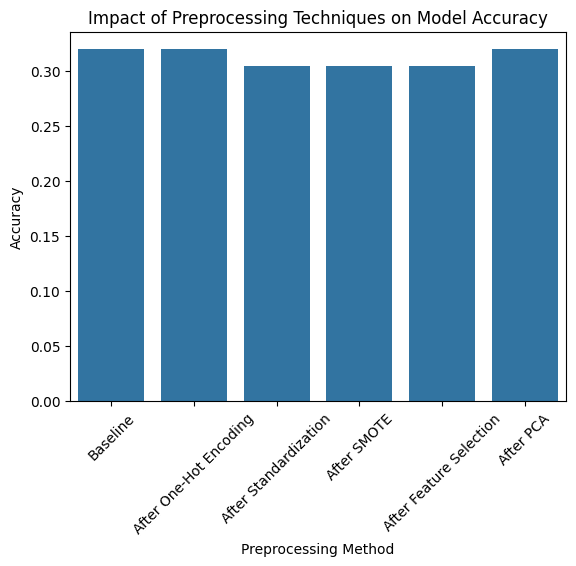

In [14]:
# Cell 12: Summary of Results
results = {
    "Baseline": baseline_accuracy,
    "After One-Hot Encoding": accuracy_encoded,
    "After Standardization": accuracy_scaled,
    "After SMOTE": accuracy_smote,
    "After Feature Selection": accuracy_selected,
    "After PCA": accuracy_pca
}

results_df = pd.DataFrame(list(results.items()), columns=['Preprocessing Method', 'Accuracy'])
sns.barplot(data=results_df, x='Preprocessing Method', y='Accuracy')
plt.title('Impact of Preprocessing Techniques on Model Accuracy')
plt.xticks(rotation=45)
plt.show()

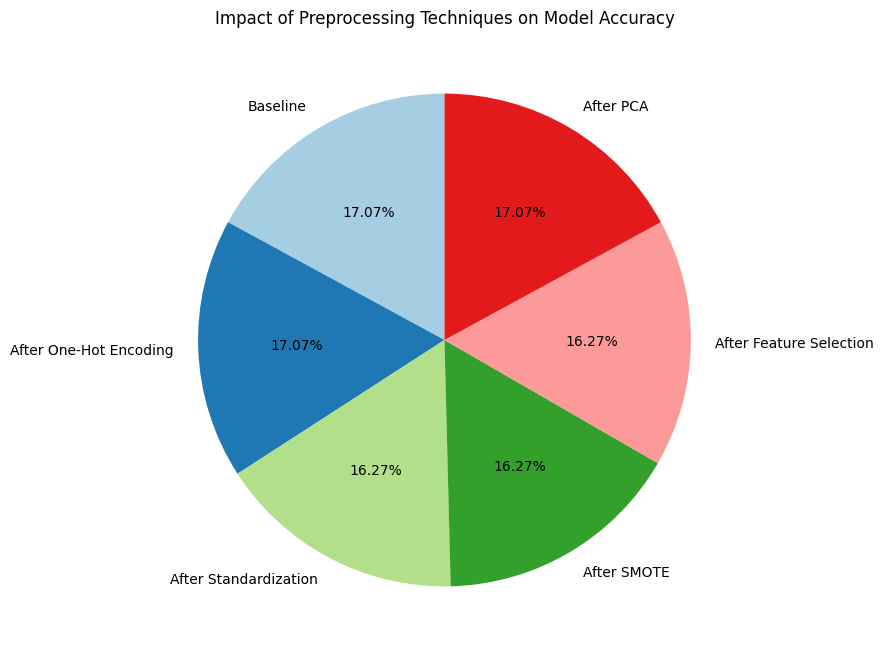

In [16]:
import matplotlib.pyplot as plt



# Prepare data for the pie chart
labels = results.keys()
sizes = [accuracy * 100 for accuracy in results.values()]  # Convert to percentage

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Impact of Preprocessing Techniques on Model Accuracy')
plt.show()


In [19]:

accuracies = [
    ("Baseline", baseline_accuracy * 100),
    ("Standardization",accuracy_scaled * 100),
    ("Encoded", accuracy_encoded * 100),
    ("SMOTE", accuracy_smote * 100),
    ("Feature Selection", accuracy_selected * 100),
    ("PCA", accuracy_pca* 100)
]
# Convert the list into a DataFrame
accuracy_df = pd.DataFrame(accuracies, columns=["Model", "Accuracy (%)"])

# Display the table
print(accuracy_df)

               Model  Accuracy (%)
0           Baseline          32.0
1    Standardization          30.5
2            Encoded          32.0
3              SMOTE          30.5
4  Feature Selection          30.5
5                PCA          32.0
